# MF를 이용한 추천시스템
- 정확률 평가
- 6-3의 셔플하는 것을 더 이해하는 것이 중요

## Data load

In [10]:
import numpy as np
import pandas as pd

In [11]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/Users/jun/Library/Mobile Documents/com~apple~CloudDocs/Github/ai _recommendation _system/data/u.user', sep='|', names=u_cols, encoding='latin-1')

In [12]:
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown',
          'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
          'Thriller', 'War', 'Western']
movies = pd.read_csv('/Users/jun/Library/Mobile Documents/com~apple~CloudDocs/Github/ai _recommendation _system/data/u.item', sep='|', names=i_cols, encoding='latin-1')
movies.head()

,movie_id,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/Users/jun/Library/Mobile Documents/com~apple~CloudDocs/Github/ai _recommendation _system/data/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [15]:
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


## train, test dataset 분리
- 앞의 CF는 sklearn의 train_test_split을 사용하였는데, 여기서는 sklearn의 shuffle을 사용
- `무작위 분할(shuffle)`
    - 앞에서는 stratified sampling을 사용해서 각 사용자의 데이터 중 반드시 일부는 train set에 일부는 test set에 들어가도록 하였지만 여기서는 무작위이기 때문에 극단적인 경우 어떤 사용자의 모든 데이터가 train set이나 test set 한 곳에 다 들어갈 수도 있다.
    - 특정 사용자에 대한 모든 데이터가 train set 또는 test set에 포함될 수 있는 단점이 존재,
    - 이는 현실에서 발생할 수 있는 다양한 시나리오를 반영한다.

In [16]:
# shuffle을 사용하여 train, test dataset에 고르게 배정되지 않을 수 있음
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75 # test set 25% 비율로 지정

ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings)) # 전체 데이터 중 Train_set의 비율에 해당하는 데이터가 몇 개인지 계산
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

## MF Class
- 사용자-아이템 평점 예측을 수행하는 클래스
- **사용자-아이템 상호작용 행렬(R)** 을 기반으로 각 사용자와 아이템의 **잠재요인(latent factors)** 을 학습하고, 이를 통해 평점을 예측

In [17]:
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings) # 사용자 - 아이템 평점 행렬 : Numpy 배열로 변환
        
##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i]) # 아이디를 인덱스로 매핑해 주는 맵 item_id_index에 현재 아이템의 아이디와 인덱스를 저장
            index_item_id.append([i, one_id]) # 반대로 인덱스를 아이디로 매핑해 주는 맵 index_item_id에 현재 아이템의 인덱스와 아이디를 저장
        self.item_id_index = dict(item_id_index) # 아이템ID -> 인덱스
        self.index_item_id = dict(index_item_id) # 인덱스 -> 아이템ID
        
        user_id_index = []                         # 위와 같은 작업을 사용자 아이디에 대해 실행
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index) # 사용자 ID -> 인덱스
        self.index_user_id = dict(index_user_id) # 인덱스 -> 사용자 ID (원래대로 되돌림)
        
#### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y) # 사용자-아이템 조합에 대해 예측 평점 계산
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        
        return np.sqrt(np.mean(self.errors**2))

    # 사용자 i 및 항목 j에 대한 ratings
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction) # 예측 오차 계산

            # bias update
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            # latent factors matrix update
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            try:
              x = self.user_id_index[ratings_test.iloc[i, 0]]
              y = self.item_id_index[ratings_test.iloc[i, 1]]
              z = ratings_test.iloc[i, 2]
              test_set.append([x, y, z])
              self.R[x, y] = 0                    # Setting test set ratings to 0
            except:
              print(i)
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) # 잠재요인 행렬 P와 Q를 랜덤 값으로 초기화
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # 주어진 user_id 및 item_id에 대한 ratings 지정 / (특정 사용자와 아이템의 예측 평점을 반환)
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id]) 

    # Full user-movie rating matrix / (사용자-아이템 평점 행렬의 전체 예측 값을 반환)
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)


- 효율적인 데이터 처리
    - ID를 바로 행렬에 사용할 경우, 매우 큰 차원을 가지는 희소 행렬이 생성될 수 있다.
    - ID를 인덱스로 변환하면 행렬의 크기를 최소화할 수 있다.

- **SGD(Stochastic Gradient Descent)**
    - 사용자-아이템 평점 행렬을 분해하는 데 사용되는 최적화 알고리즘
    - 전체 데이터를 반복적으로 학습하면서 최적의 파라미터를 찾는 방식
    - 전체 데이터를 한 번 반복하는 것을 **에포크(epoch)** 라고 함
    - 에포크가 끝날 때마다 전체 데이터에 대한 오차를 계산하고 이 오차를 최소화하는 방향으로 파라미터를 업데이트

- Train RMSE와 Test RMSE를 각각 계산하는 이유
    - 과적합이나 일반화 성능을 평가하기 위해 사용
    1. Train RMSE
        - 학습 데이터셋에 대해 모델이 얼마나 잘 예측하는지를 측정
        - 이 값은 모델이 학습 데이터에서 얼마나 잘 학습했는지를 보여줌
    2. Test RMSE
        - 테스트 데이터셋에 대해 모델이 얼마나 잘 일반화 되는지를 측정
        - 이 모델이 보지 못한 데이터(새로운 데이터)에서 얼마나 정확하게 예측할 수 있는 지를 나타냄

# 최적의 K값 찾기

In [18]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50, 261, 10):
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)


K = 50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9241 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9197 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9164 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9134 ; Test RMSE = 0.9466
Iteration: 80 ; Train RMSE = 0.9104 ; Test RMSE = 0.9454
Iteration: 90 ; Train RMSE = 0.9068 ; Test RMSE = 0.9443
Iteration: 100 ; Train RMSE = 0.9023 ; Test RMSE = 0.9428
Iteration: 110 ; Train RMSE = 0.8961 ; Test RMSE = 0.9409
Iteration: 120 ; Train RMSE = 0.8878 ; Test RMSE = 0.9384
Iteration: 130 ; Train RMSE = 0.8770 ; Test RMSE = 0.9352
Iteration: 140 ; Train RMSE = 0.8638 ; Test RMSE = 0.9316
Iteration: 150 ; Train RMSE = 0.8487 ; Test RMSE = 0.9281
Iteration: 160 ; Train RMSE = 0.8320 ; Test RMSE = 0.9249
Iteration: 170 ; Train RMSE = 0.8139 ; Test RMSE = 0.9223
Iteration: 180 ;

In [19]:
# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])


In [20]:
summary

[[50, 204, np.float64(0.9180944414552399)],
 [60, 210, np.float64(0.9174219435318853)],
 [70, 217, np.float64(0.9149633275138546)],
 [80, 221, np.float64(0.9143756965888005)],
 [90, 228, np.float64(0.911954869553031)],
 [100, 233, np.float64(0.9125110893087457)],
 [110, 234, np.float64(0.9116910053872911)],
 [120, 240, np.float64(0.9108017724210864)],
 [130, 238, np.float64(0.9115742157289871)],
 [140, 241, np.float64(0.9107331372844174)],
 [150, 247, np.float64(0.9086859139777731)],
 [160, 247, np.float64(0.9103936946677585)],
 [170, 247, np.float64(0.9102937799243129)],
 [180, 252, np.float64(0.9093328484444416)],
 [190, 251, np.float64(0.9101112648124442)],
 [200, 254, np.float64(0.9097340694840883)],
 [210, 256, np.float64(0.9097366006714546)],
 [220, 256, np.float64(0.9095693922921099)],
 [230, 257, np.float64(0.9097444292617776)],
 [240, 260, np.float64(0.9089042840211536)],
 [250, 261, np.float64(0.9090273015736764)],
 [260, 261, np.float64(0.9089027840737741)]]

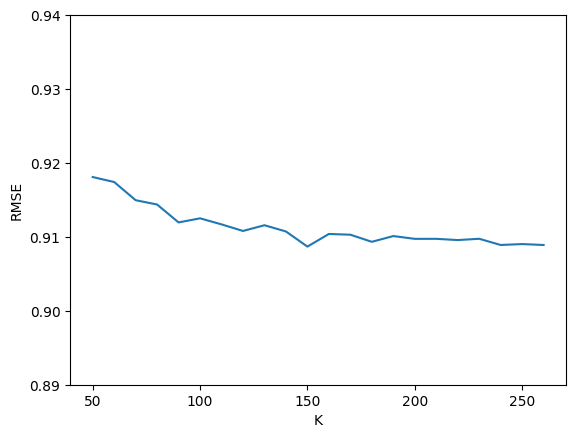

In [21]:
# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()